# Imports

In [7]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# 1. Dataset Preparation & Analysis

## 1.2 - Loading the dataset

In [8]:
import random
data = pd.read_csv("../SOEN-471-Music-Recommender-System/data/data.csv")
genre_data = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_by_genres.csv')
year_data = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_by_year.csv')
p = 0.08 
df_playlist = pd.read_csv('../SOEN-471-Music-Recommender-System/data/data_playlist.csv', error_bad_lines=False, warn_bad_lines=False, skiprows=lambda i: i>0 and random.random() > p)

## 1.6 - Collaborative Based Recommendation

* Prepare playlist data for collaborative based model

In [17]:
data['artists'] = data['artists'].map(lambda x: x.lstrip('[').rstrip(']'))
data.head()
data['artists'] = data['artists'].map(lambda x: x[1:-1])
data.head()
df_playlist.head()

df_playlist.columns = df_playlist.columns.str.replace('"', '')
df_playlist.columns = df_playlist.columns.str.replace('name', '')
df_playlist.columns = df_playlist.columns.str.replace(' ', '')
df_playlist.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

* In order to avoid the impact of cold start problem, we require the playlists to contain at least 10 unique artists, where artists have frequencies higher than 50.
* Then, group the user and the frequency of the artists in their playlist


In [18]:
df_playlist = df_playlist.groupby('artist').filter(lambda x : len(x)>=50)
df_playlist = df_playlist[df_playlist.groupby('user_id').artist.transform('nunique') >= 10]

size = lambda x: len(x)
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq.head()

,user_id,artist,freq
293868,defced0ece4ce946160b0d2698142eac,Vitamin String Quartet,263
52064,26b51e580277e131f87e4c7ee4c0887a,Vitamin String Quartet,256
87553,414050deadb38aafd8d4ad22ca634055,Vitamin String Quartet,187
234407,b1d4116e7cf150ae7d77413620f5f571,Wolfgang Amadeus Mozart,181
329820,fa849dabeb14a2800ad5130907fc5018,Peggy Lee,176


In [19]:
df_artist = pd.DataFrame(df_freq["artist"].unique())
df_artist = df_artist.reset_index()
df_artist = df_artist.rename(columns={'index':'artist_id', 0:'artist'})
df_artist.head()

def GetInPut(user):
    inputArtist = pd.DataFrame(user)
    #Filtering out the artists
    Id = df_artist[df_artist['artist'].isin(inputArtist['artist'].tolist())]
    inputArtist = pd.merge(Id, inputArtist)
    return inputArtist

userPlaylist = [
            {'artist':'Ella Fitzgerald', 'freq':40},
            {'artist':'Frank Sinatra', 'freq':10},
            {'artist':'Lil Wayne', 'freq':3},
            {'artist':"The Rolling Stones", 'freq':5},
            {'artist':'Louis Armstrong', 'freq':5}
         ] 
inputPlaylist=GetInPut(userPlaylist)
print(inputPlaylist)

   artist_id              artist  freq
0          4     Ella Fitzgerald    40
1          7       Frank Sinatra    10
2         13     Louis Armstrong     5
3         15  The Rolling Stones     5
4         33           Lil Wayne     3


We will use Pearson Correlation in order to find the similarities between users depending on the artists appearing on their playlists
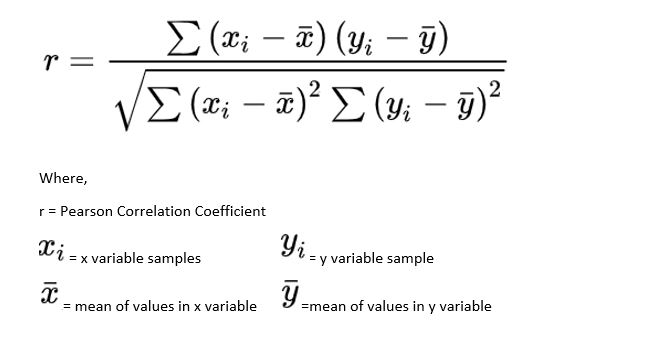

In [20]:

from cmath import sqrt

def collab_filter(input_artist, freq_df):
    artist_id = df_artist[df_artist['artist'].isin(input_artist['artist'].tolist())]
    input_artist = pd.merge(artist_id, input_artist)
    freq_df = pd.merge(freq_df, df_artist, how='inner', on='artist')
    user_group = freq_df.groupby(['user_id'])
    user_group = sorted(user_group, key=lambda x: len(x[1]), reverse=True)
    user_group = user_group[0:100]

    pearson_corr = {}

    for user, group in user_group:
        group = group.sort_values(by='artist_id')
        input_artist = input_artist.sort_values(by='artist_id')
        num = len(group)

        temp_df = input_artist[input_artist['artist_id'].isin(group['artist_id'].tolist())]
        temp_rating = temp_df['freq'].tolist()
        temp_group = group['freq'].tolist()

        Sxx = sum([i**2 for i in temp_rating]) - pow(sum(temp_rating), 2) / float(num)
        Syy = sum([i**2 for i in temp_group]) - pow(sum(temp_group), 2) / float(num)
        Sxy = sum(i * j for i, j in zip(temp_rating, temp_group)) - sum(temp_rating) * sum(temp_group) / float(num)

        if Sxx != 0 and Syy != 0:
            pearson_corr[user] = Sxy / sqrt(Sxx * Syy)
        else:
            pearson_corr[user] = 0

    pearson_df = pd.DataFrame.from_dict(pearson_corr, orient='index')
    pearson_df.columns = ['similarityIndex']
    pearson_df['user_id'] = pearson_df.index
    pearson_df.index = range(len(pearson_df))
    top_users = pearson_df.sort_values(by='similarityIndex', ascending=False)[0:50]
    top_users_ratings = top_users.merge(freq_df, left_on='user_id', right_on='user_id', how='inner')

    top_users_ratings['weightedFreq'] = top_users_ratings['similarityIndex'] * top_users_ratings['freq']

    temp_ratings = top_users_ratings.groupby('artist_id').sum()[['similarityIndex', 'weightedFreq']]
    temp_ratings.columns = ['sum_similarityIndex', 'sum_weightedFreq']

    recommendations = pd.DataFrame()
    recommendations['weighted_avg_freq_score'] = temp_ratings['sum_weightedFreq'] / temp_ratings['sum_similarityIndex']
    recommendations['artist_id'] = temp_ratings.index
    recommendations = recommendations.sort_values(by='weighted_avg_freq_score', ascending=False)
    final_recommendations = df_artist.loc[df_artist['artist_id'].isin(recommendations.head(15)['artist_id'].tolist())]

    return final_recommendations, top_users_ratings

final_recommendations, top_users_ratings = collab_filter(inputPlaylist, df_freq)
final_recommendations



,artist_id,artist
2,2,Peggy Lee
4,4,Ella Fitzgerald
7,7,Frank Sinatra
8,8,Jamey Aebersold Play-A-Long
13,13,Louis Armstrong
15,15,The Rolling Stones
34,34,Nat King Cole
38,38,John Zorn
40,40,Noël Akchoté
50,50,B.B. King


In [21]:
def evaluate_recommender(userPlaylist, final_recommendations):
    # Convert recommended artists to a set for easy comparison
    recommended_artists = set(final_recommendations['artist'].tolist())
    # Convert user playlist to a set for easy comparison
    user_artists = set([item['artist'] for item in userPlaylist])
    # Calculate precision
    precision = len(recommended_artists.intersection(user_artists)) / len(recommended_artists)
    # Calculate recall
    recall = len(recommended_artists.intersection(user_artists)) / len(user_artists)
    # Calculate F1-score
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

precision, recall, f1_score = evaluate_recommender(userPlaylist, final_recommendations)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.26666666666666666
Recall: 0.8
F1-score: 0.4
